In [ ]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz
%autoreload 2
%matplotlib notebook

from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from fastai2.basics import *
from fastai2.callback.schedule import *
from fastai2.callback.rnn import *
from fastai2.callback.tracker import *

## Input Only

In [ ]:
f_paths = '/mnt/Data/Systemidentification/MDT_Benchmark/'
hdf_files = get_hdf_files(f_paths)
u=['indicated torque','boost pressure','EGR rate','start of injection','rail pressure','engine speed']
# y=['HC measured','NOx measured']
y=['NOx measured']

seq = DataBlock(blocks=(SequenceBlock.from_hdf(u,TensorSequencesInput),
                        SequenceBlock.from_hdf(y,TensorSequencesOutput)),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=300,stp_sz=3,clm='EGR rate')]),
                 splitter=FuncSplitter(lambda o: 'test' in str(o['path']) ))

db = seq.databunch(hdf_files,shufflish=True,bs=32)

<IPython.core.display.Javascript object>


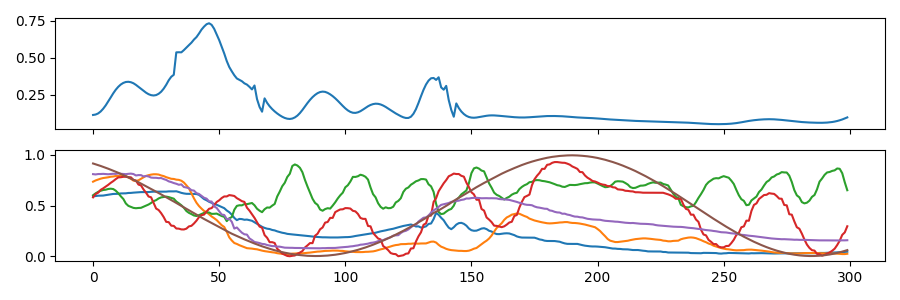

In [ ]:
db.show_batch(max_n=1)

In [ ]:
model = SimpleGRU(6,2,num_layers=2,hidden_size=100)
# model = SimpleLSTM(6,1,num_layers=3,hidden_size=100,dropout=0.1)
# model = SimpleQRNN(6,1,hidden_size=100,n_layers=6,window=2,zoneout=0.0)
# model = TCN(6,1,hl_depth=7,hl_width=100)
# model = ConvGRU(6,1,num_ft=10,num_cnn_layers=8,hs_cnn=10,hs_rnn=100)
# model = ConvQRNN(6,1,num_ft=50,num_cnn_layers=8,num_rnn_layers=2)

In [ ]:
skip = partial(SkipNLoss,n_skip=128)
lrn = Learner(db,model,loss_func=skip(nn.MSELoss()),opt_func=ranger,metrics=[skip(norm_rmse)],
              cbs=RNNRegularizer(alpha=1,beta=1,modules=[model.conv_layers[-1]]))

In [ ]:
skip = partial(SkipNLoss,n_skip=16)
lrn = Learner(db,model,loss_func=nn.MSELoss(),opt_func=ranger,metrics=[skip(norm_rmse)],
              cbs=[TimeSeriesRegularizer(alpha=3,beta=1,modules=[model.rnn]),
                   SaveModelCallback(),EarlyStoppingCallback(patience=5)])

NameError: name 'model' is not defined

In [ ]:
lrn = TCNLearner(db,hl_depth=4,early_stop=5)

<IPython.core.display.Javascript object>


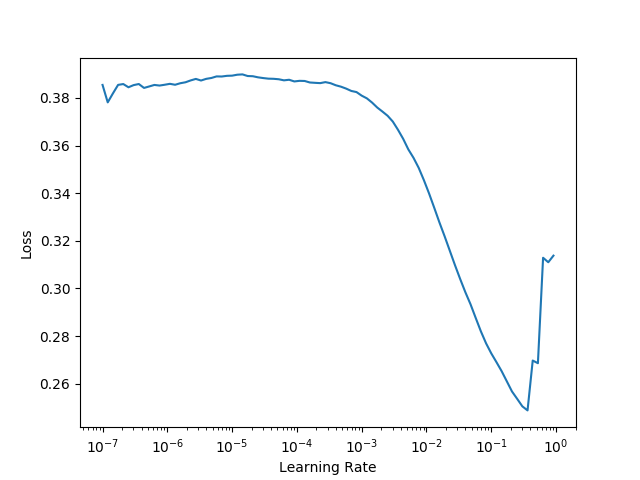

In [ ]:
lrn.lr_find()

In [ ]:
lrn.fit_one_cycle(100,lr_max=3e-2,pct_start=0.05,wd=0.1)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.116215,0.038393,0.195351,00:06
1,0.018724,0.008384,0.088223,00:06
2,0.006427,0.004083,0.061560,00:07
3,0.004718,0.003179,0.055118,00:06
4,0.004008,0.002922,0.053678,00:06
5,0.003534,0.002812,0.052621,00:06
6,0.003079,0.002535,0.049973,00:06
7,0.002948,0.007213,0.081089,00:06


No improvement since epoch 6: early stopping


<IPython.core.display.Javascript object>


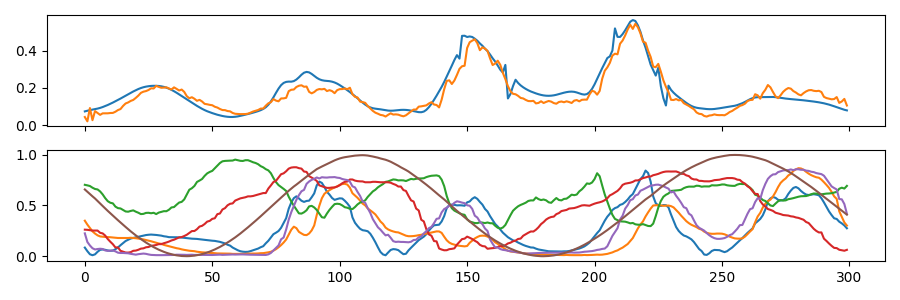

<IPython.core.display.Javascript object>


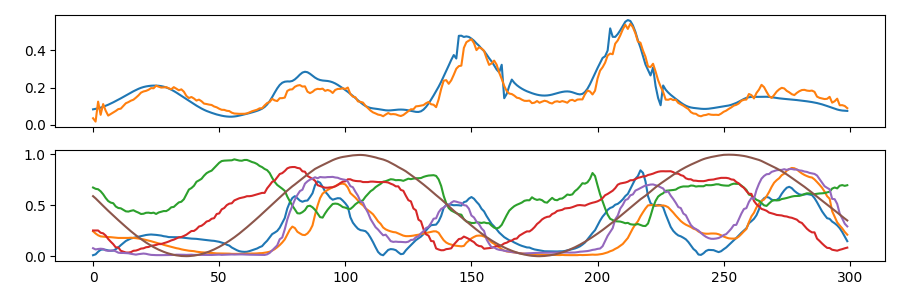

In [ ]:
lrn.show_results(ds_idx=1,max_n=2)

## Test

<IPython.core.display.Javascript object>


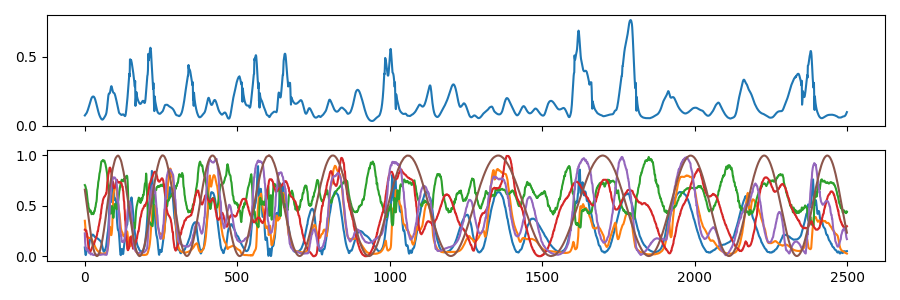

In [ ]:
f_tst = L([f for f in get_hdf_files(f_paths) if 'test' in str(f)])
db_tst = (DataBlock(blocks=(SequenceBlock.from_hdf(u,TensorSequencesInput),#,clm_shift=[-11000]),
                        SequenceBlock.from_hdf(y,TensorSequencesOutput)),#,clm_shift=[-11000])),
                     splitter=IndexSplitter(None))
            .databunch(f_tst,bs=1))
db_tst.after_batch[1].mean = db.after_batch[1].mean 
db_tst.after_batch[1].std = db.after_batch[1].std 
db_tst.show_batch(max_n=1)

<IPython.core.display.Javascript object>


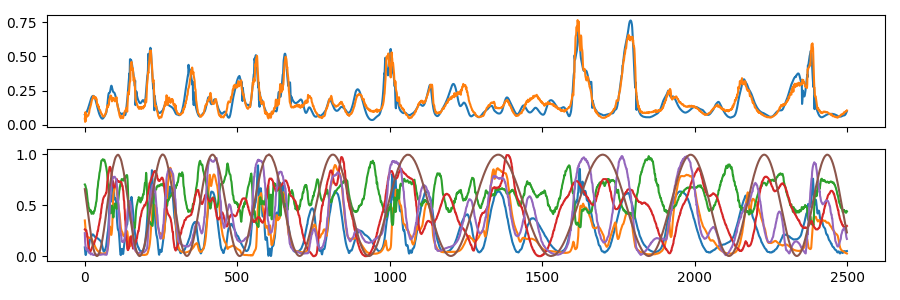

In [ ]:
lrn.show_results(dl=db_tst.train_dl)

In [ ]:
lrn.validate(dl=db_tst.train_dl)

(#2) [0.002502228831872344,0.05002228170633316]